In [2]:
import numpy as np
import os
import pandas as pd
from matplotlib import mlab
import matplotlib.pyplot as plt

from src.data.make_dataset import BCIDataset
from src.visualization.plotting import plot_data, plot_data_logvar, plot_LDA
from src.data.signal_processing import best_csp_components

%load_ext autoreload
%autoreload 2

# CSV-Files

In [39]:
classes = {'hand_right': 0, 'hand_left': 1, 'wrist_right': 2, 'wrist_left': 3}
subjects = ["anna"]
measurements = ["2023-02-20_17-35-55_no_timecorr"]

In [40]:
data_root = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/data/raw/"

## Create data class

In [41]:
mydataset = BCIDataset(data_root, subjects, measurements)

In [42]:
mydataset.data.head()

,subject,measurement,class,sampleID,path,sample
0,anna,2023-02-20_17-35-55_no_timecorr,arm_left,10,arm_left_10_1676911134.csv,Unnamed: 0 class time_in_s C...
1,anna,2023-02-20_17-35-55_no_timecorr,arm_left,11,arm_left_11_1676911150.csv,Unnamed: 0 class time_in_s C...
2,anna,2023-02-20_17-35-55_no_timecorr,arm_left,13,arm_left_13_1676911183.csv,Unnamed: 0 class time_in_s C...
3,anna,2023-02-20_17-35-55_no_timecorr,arm_left,15,arm_left_15_1676911217.csv,Unnamed: 0 class time_in_s C...
4,anna,2023-02-20_17-35-55_no_timecorr,arm_left,19,arm_left_19_1676911283.csv,Unnamed: 0 class time_in_s C...


### Get shapes

In [43]:
mydataset.get_shapes()

{'n_channels': 16,
 'sample_length': 500,
 'n_classes': {'arm_left': 20, 'arm_right': 20}}

### Get one sample

In [44]:
sample_idx = 4
sample, label = mydataset[sample_idx]
sample.head()

,Unnamed: 0,class,time_in_s,CZ,C4,T4,T5,P3,PZ,P4,FZ,FP1,FP2,F7,F3,F4,F8,T3,C3
60,60,arm_left,0.453594,-1.605290,4.082414,0.202566,-2.294865,4.632386,-0.443815,4.080616,-0.370287,-9.950086,-8.851130,-6.597747,-1.618181,-5.481019,-7.532168,22.452196,-0.652585
61,61,arm_left,0.461594,-16.164108,-17.309891,-17.059053,-12.170132,-16.843290,-9.458080,-9.849421,-18.931322,-8.118289,-8.040544,-5.690722,-5.586374,-0.364537,-5.865053,25.010805,-2.071347
62,62,arm_left,0.469594,0.968636,3.671647,1.851253,2.407525,1.035978,-0.094020,2.241139,2.575028,-17.336166,-17.118532,-19.512718,-11.466615,-14.401417,-16.487392,34.313538,-18.947071
63,63,arm_left,0.477594,10.804798,13.983855,16.251692,14.859405,11.563536,8.009797,14.543032,12.032655,9.769825,10.528039,9.554359,5.023335,9.345685,12.957280,42.135197,7.697255
64,64,arm_left,0.485594,-8.172122,-7.966987,-0.939149,0.396492,-5.687509,-5.505815,-2.416607,-9.546969,10.132363,11.486314,13.987518,11.875533,10.446255,16.209316,36.127258,11.920836


In [45]:
timestamps = np.array(sample['time_in_s'])

In [46]:
np.ediff1d(timestamps)[0:40]

array([ 0.008    ,  0.008    ,  0.008    ,  0.008    ,  0.012725 ,
        0.008    ,  0.008    ,  0.008    ,  0.008    ,  0.0108251,
        0.008    ,  0.008    ,  0.008    ,  0.008    ,  0.0209821,
        0.008    ,  0.008    ,  0.008    ,  0.008    ,  0.0195513,
        0.008    ,  0.008    ,  0.008    ,  0.008    , -0.0107238,
        0.008    ,  0.008    ,  0.008    ,  0.008    ,  0.0152043,
        0.008    ,  0.008    ,  0.008    ,  0.008    , -0.0120031,
        0.008    ,  0.008    ,  0.008    ,  0.008    ,  0.0046672])

## Validate data

In [47]:
mydataset.validate_data()

Total invalid samples: 0


In [48]:
sample_values = mydataset.get_sample_values(3, selected_data="sample")
np.shape(sample_values[:,3])

(500,)

### Plot PSD of Raw Data

(40, 251, 16)


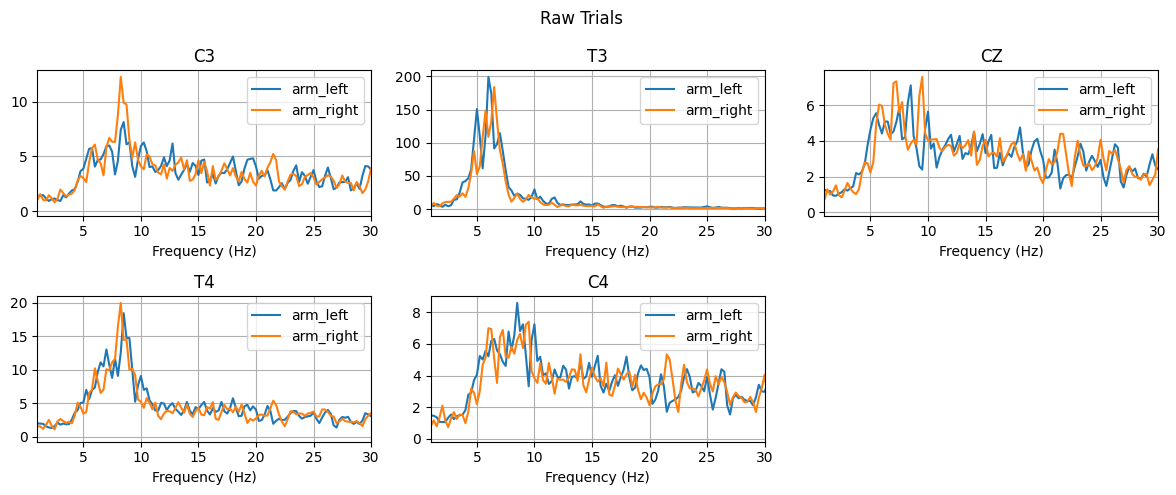

In [49]:
plot_data(mydataset, title="Raw Trials", selected_data="sample")

## Preprocess data

### Bandpass Filter

In [50]:
mydataset.apply_bandpass_filtering(selected_data="sample")

### Plot PSD of filtered data

(40, 251, 16)


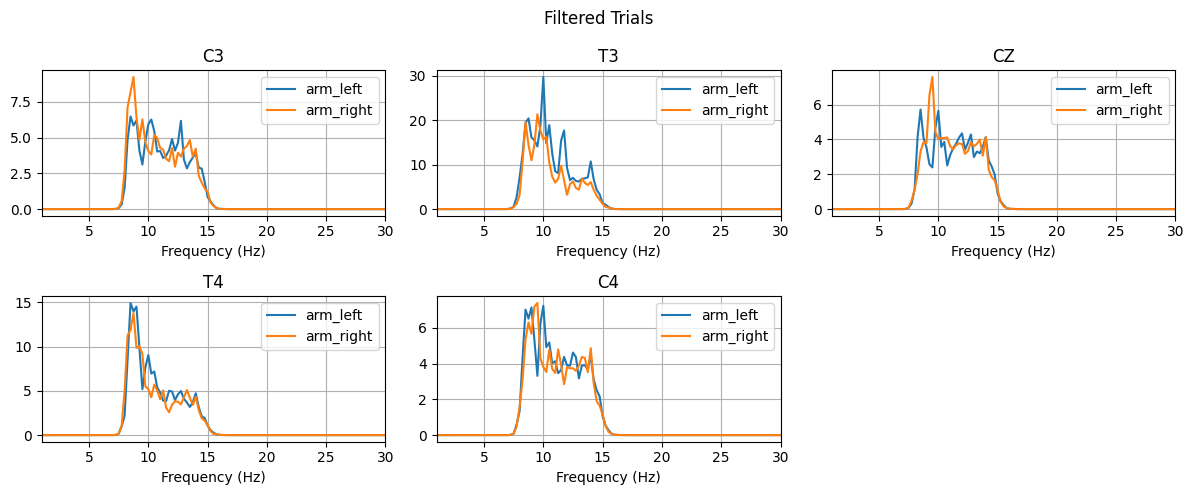

In [52]:
plot_data(mydataset, title="Filtered Trials", selected_data="filtered")

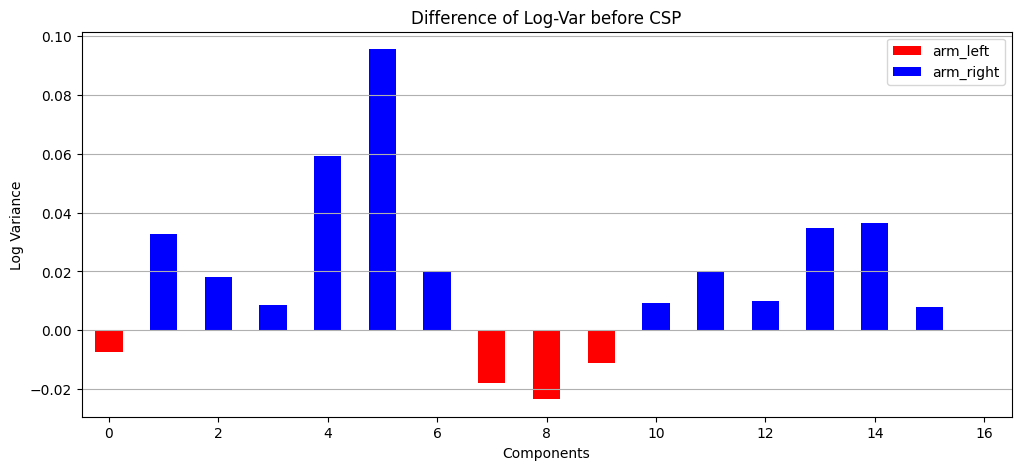

In [53]:
plot_data_logvar(mydataset, selected_data="filtered", mode="diff", title="before CSP")

## CSP (Common Spatial Pattern)

CSP designs a set of spatial filters so that the filtered signal’s variance is maximal for one class while minimal for the other one.
It estimates the spatial covariance for each EEG trial with size (n_channels, n_samples).

In [54]:
csp_Matrix = mydataset.calc_csp(only_train=False, selected_data='filtered')
mydataset.apply_csp(selected_data="filtered")

(40, 251, 16)


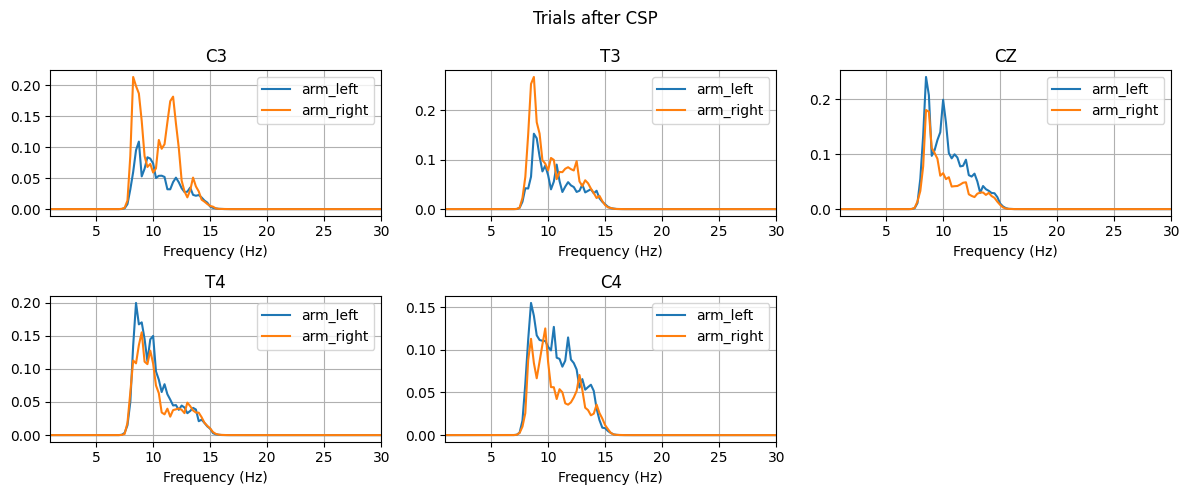

In [56]:
plot_data(mydataset, title="Trials after CSP", selected_data="csp")

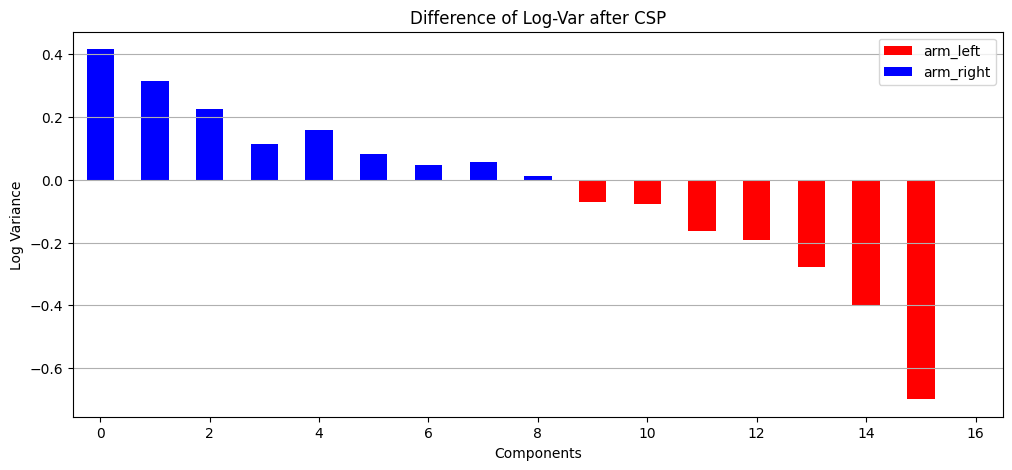

In [57]:
plot_data_logvar(mydataset, selected_data="csp", mode="diff", title="after CSP")

## Choose best components

Components with highest difference of log-variance between both classes

In [58]:
data_2comp = mydataset.feature_extraction_CSP(only_train=False)
print(np.shape(data_2comp))

Best CSP components: [0, 15]
(40, 500, 2)


In [62]:
mydataset.data['filtered'][0].head()

,time_in_s,CZ,C4,T4,T5,P3,PZ,P4,FZ,FP1,FP2,F7,F3,F4,F8,T3,C3
0,0.470769,0.364034,0.304132,0.442920,0.372103,0.261686,0.293239,0.435002,0.160317,0.305376,0.251205,0.270789,-0.177054,0.410640,0.329870,-0.407221,0.213592
1,0.478768,-0.133349,0.286022,0.452025,0.020735,-0.039937,-1.577036,0.371445,1.730511,1.911371,3.062096,1.279683,4.128799,4.130568,2.913658,1.783343,-0.014359
2,0.486768,-0.298135,0.447787,0.414591,0.181830,0.370388,-2.426106,0.638899,3.059453,3.176627,4.955062,2.308797,7.171432,6.536884,4.452378,3.343972,0.060954
3,0.494768,0.061389,0.846615,0.332663,1.091222,1.769341,-1.697323,1.391094,3.909473,3.883911,5.375211,3.325867,8.137732,6.900238,4.374431,3.739628,0.621099
4,0.502768,0.783240,1.286639,0.146651,2.449968,3.703803,0.339831,2.365927,3.996079,3.842953,4.198172,4.068749,6.948111,5.180860,2.685328,2.823410,1.502631


# MAT-Files

In [165]:
data_root = "C:/Users/annag/OneDrive - Danmarks Tekniske Universitet/Semester_04/Special_Course_BCI/03_code/BCI_stroke_rehab/data/raw/"
subjects = ["BCI_course"]
measurements = ["PAT021_A"]
classnames = ["right wrist","left wrist"]
duration = 6
sample_rate = 256

In [166]:
mat_dataset = BCIDataset(data_root, subjects, measurements, classnames, sample_rate, duration, filetype="mat")
mat_dataset.data.head()

,subject,measurement,class,sampleID,path,sample
0,BCI_course,PAT021_A,right wrist,0,C:/Users/annag/OneDrive - Danmarks Tekniske Un...,time_in_s ch1 ch2 ch3...
1,BCI_course,PAT021_A,left wrist,1,C:/Users/annag/OneDrive - Danmarks Tekniske Un...,time_in_s ch1 ch2 ch3 ...
2,BCI_course,PAT021_A,right wrist,2,C:/Users/annag/OneDrive - Danmarks Tekniske Un...,time_in_s ch1 ch2 ch3...
3,BCI_course,PAT021_A,right wrist,3,C:/Users/annag/OneDrive - Danmarks Tekniske Un...,time_in_s ch1 ch2 ch3 ...
4,BCI_course,PAT021_A,left wrist,4,C:/Users/annag/OneDrive - Danmarks Tekniske Un...,time_in_s ch1 ch2 c...


In [167]:
mat_dataset.data['sample'][0].head()

,time_in_s,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16
0,0.000000,-1.075832,-2.723514,0.168148,3.254819,3.637734,-2.547610,-3.220647,-3.254831,-2.490477,-0.219320,2.957068,3.333702,0.451789,-4.081564,-4.033146,-1.064656
1,0.003906,-3.657143,-5.436400,-1.580259,1.655565,1.921840,-4.310659,-5.528933,-5.338433,-4.279742,-2.015439,0.747582,1.377365,-1.276661,-5.528731,-5.941673,-3.020358
2,0.007812,-5.910010,-7.395266,-2.941333,0.587671,0.062975,-5.607168,-6.829276,-6.004431,-5.342308,-2.407117,-0.544760,0.191823,-1.772736,-4.854354,-5.382417,-2.992874
3,0.011719,-7.114160,-8.085546,-3.722995,0.323191,-1.448621,-6.362695,-6.961522,-5.286970,-5.194376,-1.026775,-0.407237,0.428577,-1.329027,-2.277282,-2.213352,-0.600662
4,0.015625,-7.226933,-7.741441,-4.109986,0.424940,-2.425853,-6.442323,-6.047697,-3.855508,-3.744331,1.524592,0.907767,1.646668,-0.549005,1.153902,2.339494,3.119517


(1236, 769, 16)


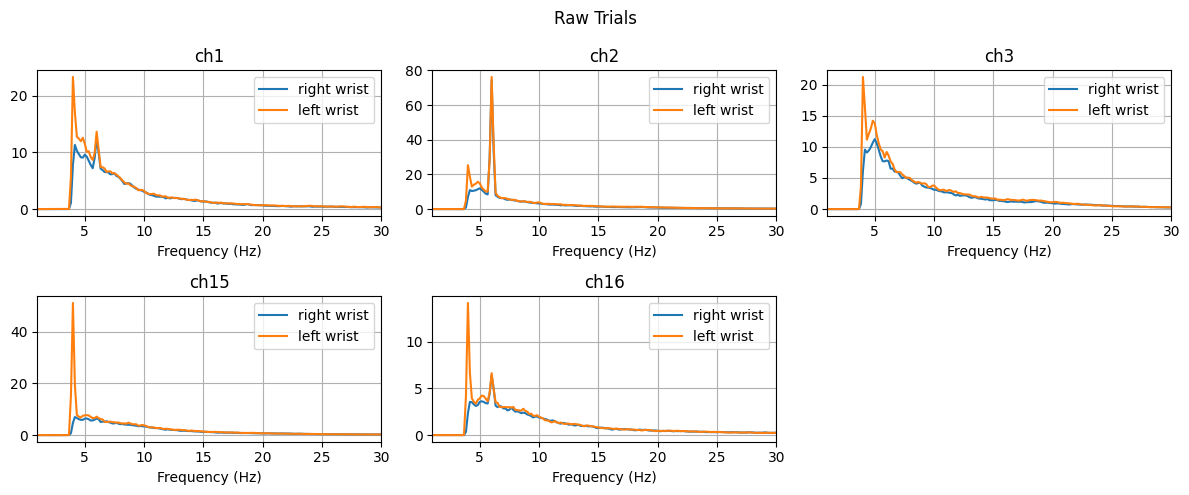

In [168]:
plot_data(mat_dataset, title="Raw Trials", channels=['ch1','ch2','ch3','ch15','ch16'], selected_data="sample")

### Preprocess

In [169]:
# Validate
mat_dataset.validate_data()
# Bandpass filtering
mat_dataset.apply_bandpass_filtering(selected_data="sample", low_f=4, high_f=40)

Total invalid samples: 1


(1235, 769, 16)


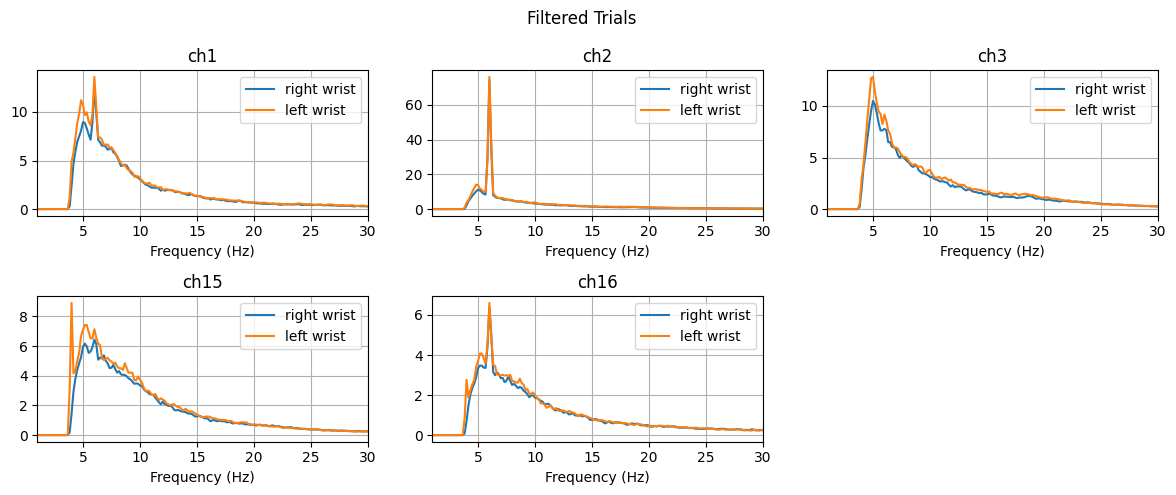

In [170]:
plot_data(mat_dataset, title="Filtered Trials", channels=['ch1','ch2','ch3','ch15','ch16'], selected_data="filtered")

### Create Training data

In [222]:
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [223]:
mode = ["class_as_array","class_as_key"][0]
test_size = 0.3

In [305]:
training_data = mat_dataset.create_training_data(test_size, mode,selected_data="filtered", best2components=False)
print(training_data.keys())

Split dataset in 864 train and 371 test samples.
Test indexes: [144, 1098, 207, 256, 1124, 911, 685, 989, 1157, 1116, 971, 431, 623, 419, 99, 407, 312, 920, 732, 734, 1122, 35, 126, 687, 1009, 456, 41, 326, 1052, 1127, 413, 930, 671, 433, 1001, 694, 110, 540, 849, 565, 384, 162, 347, 589, 462, 611, 642, 1089, 797, 282, 624, 857, 470, 1086, 46, 421, 610, 316, 839, 645, 285, 479, 924, 368, 19, 888, 260, 481, 759, 792, 866, 490, 1154, 72, 841, 602, 133, 188, 1209, 787, 1195, 1171, 1054, 830, 102, 592, 465, 1183, 397, 731, 771, 615, 925, 845, 71, 142, 336, 1072, 119, 562, 868, 992, 441, 405, 932, 357, 998, 40, 831, 973, 194, 167, 416, 124, 848, 291, 30, 380, 862, 622, 896, 746, 448, 152, 408, 417, 786, 1051, 1031, 494, 338, 697, 556, 116, 398, 307, 469, 1077, 813, 774, 64, 733, 401, 802, 370, 635, 85, 649, 1150, 542, 934, 747, 908, 386, 1032, 655, 329, 90, 222, 138, 977, 218, 39, 229, 777, 879, 1181, 809, 460, 356, 97, 1033, 449, 729, 168, 268, 750, 691, 415, 751, 148, 528, 843, 1058, 1048

In [306]:
training_data['train'].keys()
print(np.shape(training_data['train']['X']))

(864, 16)


### LDA

In [307]:
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis())

In [308]:
lda.fit(training_data['train']['X'], training_data['train']['y'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lineardiscriminantanalysis', LinearDiscriminantAnalysis())])

In [309]:
mean_acc = lda.score(training_data['test']['X'], training_data['test']['y'])

In [310]:
mean_acc

0.7978436657681941

### SVM

In [311]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [312]:
svm.fit(training_data['train']['X'], training_data['train']['y'])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [313]:
mean_acc = svm.score(training_data['test']['X'], training_data['test']['y'])
print(mean_acc)

0.8005390835579514


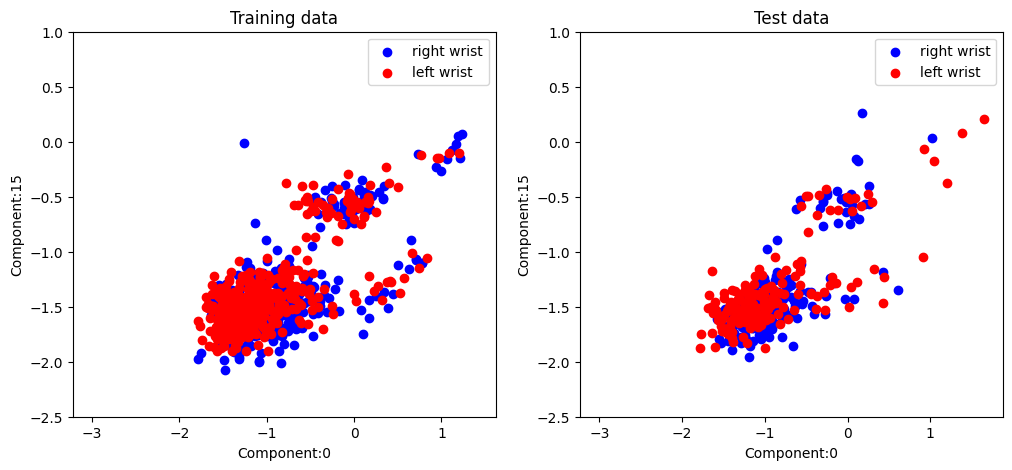

In [181]:
plot_LDA(training_data['train'], training_data['test'], b, W, mat_dataset.classes, mat_dataset.selected_csp_components)